In [20]:
"""
Solution code for the problem "Cart-pole balance".

Autonomous Systems Lab (ASL), Stanford University
"""

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

from animations import animate_cartpole

# Constants
n = 4  # state dimension
m = 3  # control dimension
dt = 0.1  # discretization time step
animate = False  # whether or not to animate results

r = 0.05
a = 0.05
b1 = 0.05
b2 = 0.05
b3 = 0.05
l1 = 0.3
l_cm1 = 0.2
I1 = 0.007
I2 = 0.07
tau1 = 1.0
tau2 = 1.0


def cartpole(s: np.ndarray, u: np.ndarray) -> np.ndarray:
    """Compute the cart-pole state derivative

    Args:
        s (np.ndarray): The cartpole state: [x, theta, x_dot, theta_dot], shape (n,)
        u (np.ndarray): The cartpole control: [F_x], shape (m,)

    Returns:
        np.ndarray: The state derivative, shape (n,)
    """
    theta1, theta2, dtheta1, dtheta2 = s
    T1, T2, T3 = u
    ds = np.array(
        [
            dtheta1,
            dtheta2,
           (1 / I1) * (T1 / r * (b1 * (np.sqrt(a**2 + b1**2) + l1 - l_cm1)) / np.sqrt(a**2 + b1**2)+tau1),
            (1 / I2) * (tau2 - T2 * b2/r + T3 * b3 /r),
        ]
    )
    return ds



def ricatti_recursion(
    A: np.ndarray, B: np.ndarray, Q: np.ndarray, R: np.ndarray
) -> np.ndarray:
    """Compute the gain matrix K through Ricatti recursion

    Args:
        A (np.ndarray): Dynamics matrix, shape (n, n)
        B (np.ndarray): Controls matrix, shape (n, m)
        Q (np.ndarray): State cost matrix, shape (n, n)
        R (np.ndarray): Control cost matrix, shape (m, m)

    Returns:
        np.ndarray: Gain matrix K, shape (m, n)
    """
    eps = 1e-4  # Riccati recursion convergence tolerance
    max_iters = 1000  # Riccati recursion maximum number of iterations
    P_prev = np.zeros((n, n))  # initialization
    converged = False
    P = P_prev
    for i in range(max_iters):
        K = -np.linalg.inv(R + B.T @ P @ B) @ (B.T @ P @A)
        P_new = Q + A.T@ P @ A + A.T @ P@ B @ K

        # Check for convergence
        if np.max(np.abs(P_new - P)) < eps:
            print("Convergence achieved after", i, "iterations.")
            converged = True
            break
        P = P_new  
        # END PART (b) ##############################################
    if not converged:
        raise RuntimeError("Ricatti recursion did not converge!")
    print("K:", K)
    return K, P


def simulate(
    t: np.ndarray, s_ref: np.ndarray, u_ref: np.ndarray, s0: np.ndarray, K: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    """Simulate the cartpole

    Args:
        t (np.ndarray): Evaluation times, shape (num_timesteps,)
        s_ref (np.ndarray): Reference state s_bar, evaluated at each time t. Shape (num_timesteps, n)
        u_ref (np.ndarray): Reference control u_bar, shape (m,)
        s0 (np.ndarray): Initial state, shape (n,)
        K (np.ndarray): Feedback gain matrix (Ricatti recursion result), shape (m, n)

    Returns:
        tuple[np.ndarray, np.ndarray]: Tuple of:
            np.ndarray: The state history, shape (num_timesteps, n)
            np.ndarray: The control history, shape (num_timesteps, m)
    """

    def cartpole_wrapper(s, t, u):
        """Helper function to get cartpole() into a form preferred by odeint, which expects t as the second arg"""
        return cartpole(s, u)

    # PART (c) ##################################################
    # INSTRUCTIONS: Complete the function to simulate the cartpole system
    # Hint: use the cartpole wrapper above with odeint
    s = np.zeros((len(t), n))
    u = np.zeros((len(t), m))
    s[0] = s0
    Q = np.diag([50, 50, 1, 1]) 
    R = np.eye(m)  # control cost matrix
    cost = 0
    for k in range(len(t) - 1):
        u[k] = K @ (s[k] - s_ref[k]) + u_ref
        s[k+1] = odeint(cartpole_wrapper, s[k], [t[k], t[k+1]], args=(u[k],))[1]
        cost += ((s[k] - s_ref[k]).T @ Q @ (s[k] - s_ref[k]) + (u[k] - u_ref).T @ (u[k] - u_ref))
    # END PART (c) ##############################################
    return s, u, cost


def compute_lti_matrices() -> tuple[np.ndarray, np.ndarray]:
    """Compute the linearized dynamics matrices A and B of the LTI system

    Returns:
        tuple[np.ndarray, np.ndarray]: Tuple of:
            np.ndarray: The A (dynamics) matrix, shape (n, n)
            np.ndarray: The B (controls) matrix, shape (n, m)
    """
    # PART (a) ##################################################
    # INSTRUCTIONS: Construct the A and B matrices

    A_tilde = np.array([
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0]
    ])
    B_tilde = np.array([
        [0,  0,  0],
        [0,  0,  0],
        [(1 / I1) * (1 / r * (b1 * (np.sqrt(a**2 + b1**2) + l1 - l_cm1)) / np.sqrt(a**2 + b1**2)), 0, 0],
        [0,  -b2/(I2*r), b3/(I2*r)]
    ])

    A = np.eye(n) + dt* A_tilde 
    B = dt * B_tilde 
    # END PART (a) ##############################################
    return A, B


import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def plot_state_and_control_history(
    s: np.ndarray, u: np.ndarray, t: np.ndarray, s_ref: np.ndarray, name: str
) -> None:
    """Helper function for cartpole visualization

    Args:
        s (np.ndarray): State history, shape (num_timesteps, n)
        u (np.ndarray): Control history, shape (num_timesteps, m)
        t (np.ndarray): Times, shape (num_timesteps,)
        s_ref (np.ndarray): Reference state s_bar, evaluated at each time t. Shape (num_timesteps, n)
        name (str): Filename prefix for saving figures
    """
    # Plot state history
    fig_state, axes_state = plt.subplots(1, n, dpi=150, figsize=(15, 4))
    plt.subplots_adjust(wspace=0.35)
    labels_s = (r"$\theta_1(t)$", r"$\theta_2(t)$", r"$\dot{\theta}_1(t)$", r"$\dot{\theta}_2(t)$")
    s = s*180/np.pi
    s_ref = s_ref*180/np.pi
    for i in range(n):
        axes_state[i].plot(t, s[:, i], label='Actual')
        axes_state[i].plot(t, s_ref[:, i], "--", label='Reference')
        axes_state[i].set_xlabel(r"$t$")
        axes_state[i].set_ylabel(labels_s[i])
        axes_state[i].legend()
        axes_state[i].grid(True)

    plt.savefig(f"{name}_states.png", bbox_inches="tight")
    plt.show()

    # Plot control history
    fig_control, axes_control = plt.subplots(1, m, dpi=150, figsize=(15, 2))
    plt.subplots_adjust(wspace=0.35)
    labels_u = (r"$T_1(t)$", r"$T_2(t)$", r"$T_3(t)$")  # Updated to match the number of control inputs

    for i in range(m):
        axes_control[i].plot(t, u[:, i], label='Control Input')
        axes_control[i].set_xlabel(r"$t$")
        axes_control[i].set_ylabel(labels_u[i])
        axes_control[i].legend()
        axes_control[i].grid(True)

    plt.savefig(f"{name}_controls.png", bbox_inches="tight")
    plt.show()

    if animate:
        fig, ani = animate_cartpole(t, s[:, 0], s[:, 1])
        ani.save(f"{name}.mp4", writer="ffmpeg")
        plt.show()




(100, 4)


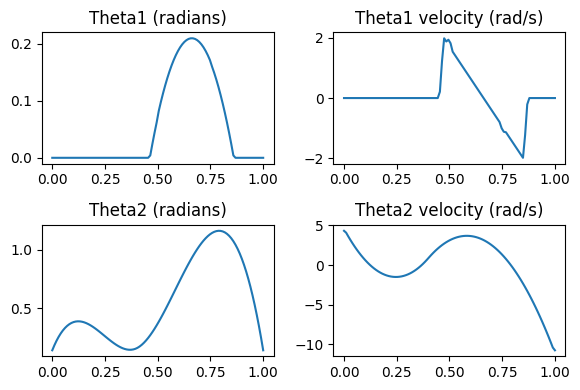

In [21]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

# Critical points for theta1
x_critical_theta1 = np.array([0, 0.14, 0.4, 0.72, 1])
y_critical_theta1 = np.array([8, 22, 9, 62, 8])

# Spline for theta1&theta2
cs_theta1 = CubicSpline(x_critical_theta1, y_critical_theta1)
x_range_theta1 = np.linspace(0, 1, 500)
y_spline_theta1 = cs_theta1(x_range_theta1)

x_spline_theta2 = np.array([0.63, 0.73, 0.83])
y_spline_theta2 = np.array([0, 12, 0])

cs_theta2 = CubicSpline(x_spline_theta2, y_spline_theta2)
x_range_theta2 = np.linspace(0.63, 0.83, 200)
y_spline_range_theta2 = cs_theta2(x_range_theta2)

num_const_before = 150
num_const_after = 150

x_full_theta2 = np.concatenate([np.linspace(0, 0.63, num_const_before), x_range_theta2, np.linspace(0.83, 1.0, num_const_after)])
y_full_theta2 = np.concatenate([np.zeros(num_const_before + 80), y_spline_range_theta2, np.zeros(num_const_after-80)])

total_time_steps = 100 
time_steps = np.linspace(0, 1, total_time_steps)

x_ref_full = np.zeros((total_time_steps, 4))
x_ref_full[:, 1] = cs_theta1(time_steps) * np.pi / 180  
x_ref_full[:, 0] = y_full_theta2[np.linspace(0, 499, total_time_steps, dtype=int)] * np.pi / 180  #
dt = 1.0 / total_time_steps  
x_ref_full[:, 2] = np.gradient(x_ref_full[:, 0], dt)  
x_ref_full[:, 3] = np.gradient(x_ref_full[:, 1], dt)  

print(x_ref_full.shape)

# Plot the reference trajectories of ankle&knee and their velocities
fig, axes = plt.subplots(2, 2, figsize=(6, 4))
axes[0, 0].plot(time_steps, x_ref_full[:, 0])
axes[0, 0].set_title('Theta1 (radians)')
axes[0, 1].plot(time_steps, x_ref_full[:, 2])
axes[0, 1].set_title('Theta1 velocity (rad/s)')
axes[1, 0].plot(time_steps, x_ref_full[:, 1])
axes[1, 0].set_title('Theta2 (radians)')
axes[1, 1].plot(time_steps, x_ref_full[:, 3])
axes[1, 1].set_title('Theta2 velocity (rad/s)')
plt.tight_layout()


Convergence achieved after 104 iterations.
K: [[-1.83618814  0.         -0.28875954  0.        ]
 [ 0.          4.3836183   0.          0.85357689]
 [ 0.         -4.3836183   0.         -0.85357689]]
(100, 4) (3,) (100,)
11.380055431963964 10.519866261863825


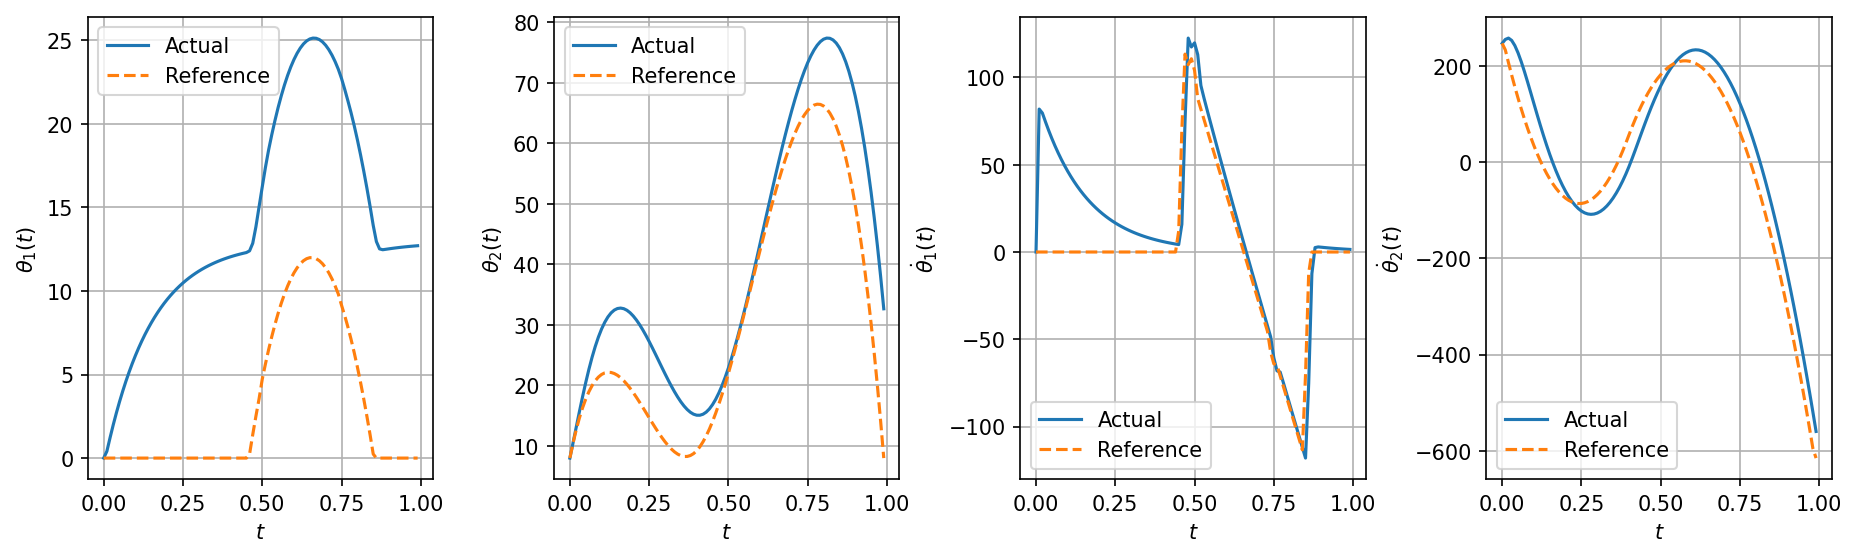

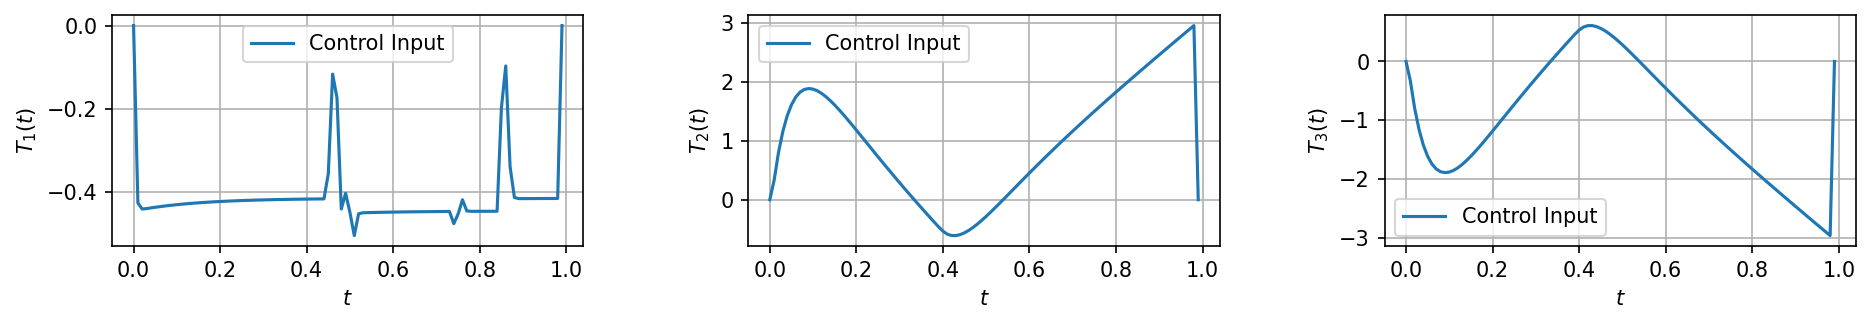

In [24]:
# if __name__ == "__emain__":
#     main()

def main():
    # Part A
    A, B = compute_lti_matrices()
    
    # Part B
    #Q = 10*np.eye(n)  # state cost matrix
    Q = np.diag([50, 50, 1, 1]) 
    R = np.eye(m)  # control cost matrix
    K, P = ricatti_recursion(A, B, Q, R)

    # Part D
    # Note: t, u_ref unchanged from part c
    s_ref = x_ref_full
    u_ref = np.array([0.0, 0.0, 0.0])
    s0 = s_ref[0]
    t = np.arange(0.0, 1.0, 1 / len(s_ref))
    print(s_ref.shape, u_ref.shape, t.shape)
    s, u, cost = simulate(t, s_ref, u_ref, s0, K)
    tracking_error = s - s_ref
    rmse_ankle = np.sqrt(np.mean((tracking_error[:, 0] * 180 / np.pi)**2))
    rmse_knee = np.sqrt(np.mean((tracking_error[:, 1] * 180 / np.pi)**2))
    print(rmse_ankle, rmse_knee)
    plot_state_and_control_history(s, u, t, s_ref, "cartpole_balance_tv")


if __name__ == "__main__":
    main()
